In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py

import tensorflow as tf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from skymapper import Map, projection

from time import time
from icecream import ic

from msfm.grid_pipeline import GridPipeline
from msfm.utils import logger, input_output, files

23-09-05 06:17:23    scales.py INF   Setting up healpy to run on 256 CPUs 


# v4 of the pipeline (multiple poisson noise realizations)

In [3]:
tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v4/large_scales/tfrecords/grid/DESy3_grid_249.tfrecord"
params = ["Om", "s8", "Aia", "bg", "n_Aia", "n_bg"]

grid_pipe = GridPipeline(
    params=params,
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    apply_norm=False
)

23-09-05 06:17:24     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
23-09-05 06:17:24     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 


In [4]:
data_vec_pix = grid_pipe.data_vec_pix
n_side = 512
n_pix = hp.nside2npix(n_side)
n_z = grid_pipe.n_z_metacal + grid_pipe.n_z_maglim
n_z_metacal = grid_pipe.n_z_metacal
n_noise = 3
filename_suffix = ""

### compare noise realizations to noiseless

In [5]:
noisy_grid_dset = grid_pipe.get_dset(
        tfr_pattern=tfr_pattern,
        n_noise=n_noise,
        local_batch_size=1,
        n_readers=1,
        n_prefetch=0,
)

dvs_noisy = []
for dv, cosmo, index in noisy_grid_dset.take(n_noise):
    dvs_noisy.append(dv)
    
dvs_noisy = np.concatenate(dvs_noisy, axis=0)
print(dvs_noisy.shape)

23-09-05 06:17:25 grid_pipelin INF   Interleaving with n_readers = 1 
23-09-05 06:17:26 grid_pipelin INF   Batching into 1 elements locally 
23-09-05 06:17:26 grid_pipelin WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23-09-05 06:17:27 grid_pipelin INF   Running on the data

In [6]:
# in degrees
x_deg = 10
y_deg = x_deg

# in pixels
x_pix = 600
y_pix = x_pix

# in arcminute / pixel
reso = x_deg / x_pix * 60

gnoms = np.zeros((len(dvs_noisy), x_pix, y_pix, n_z))

for i_n in range(len(dvs_noisy)):
    for i_z in range(n_z):
        hp_map = np.full(n_pix, hp.UNSEEN)
        hp_map[data_vec_pix] = dvs_noisy[i_n,:,i_z]

        gnom = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, xsize=x_pix, ysize=y_pix, return_projected_map=True, no_plot=True)
        gnoms[i_n, ..., i_z] = gnom

gnoms = np.ma.masked_where(gnoms==0, gnoms)

In [7]:
# reso = 600

# gnoms = np.zeros((len(dvs_noisy), reso, reso, n_z))

# for i_n in range(len(dvs_noisy)):
#     for i_z in range(n_z):
#         hp_map = np.full(n_pix, hp.UNSEEN)
#         hp_map[data_vec_pix] = dvs_noisy[i_n,:,i_z]

#         gnom = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=1, xsize=reso, ysize=reso, return_projected_map=True, no_plot=True)
#         gnoms[i_n, ..., i_z] = gnom

# gnoms = np.ma.masked_where(gnoms==0, gnoms)

### raw maps

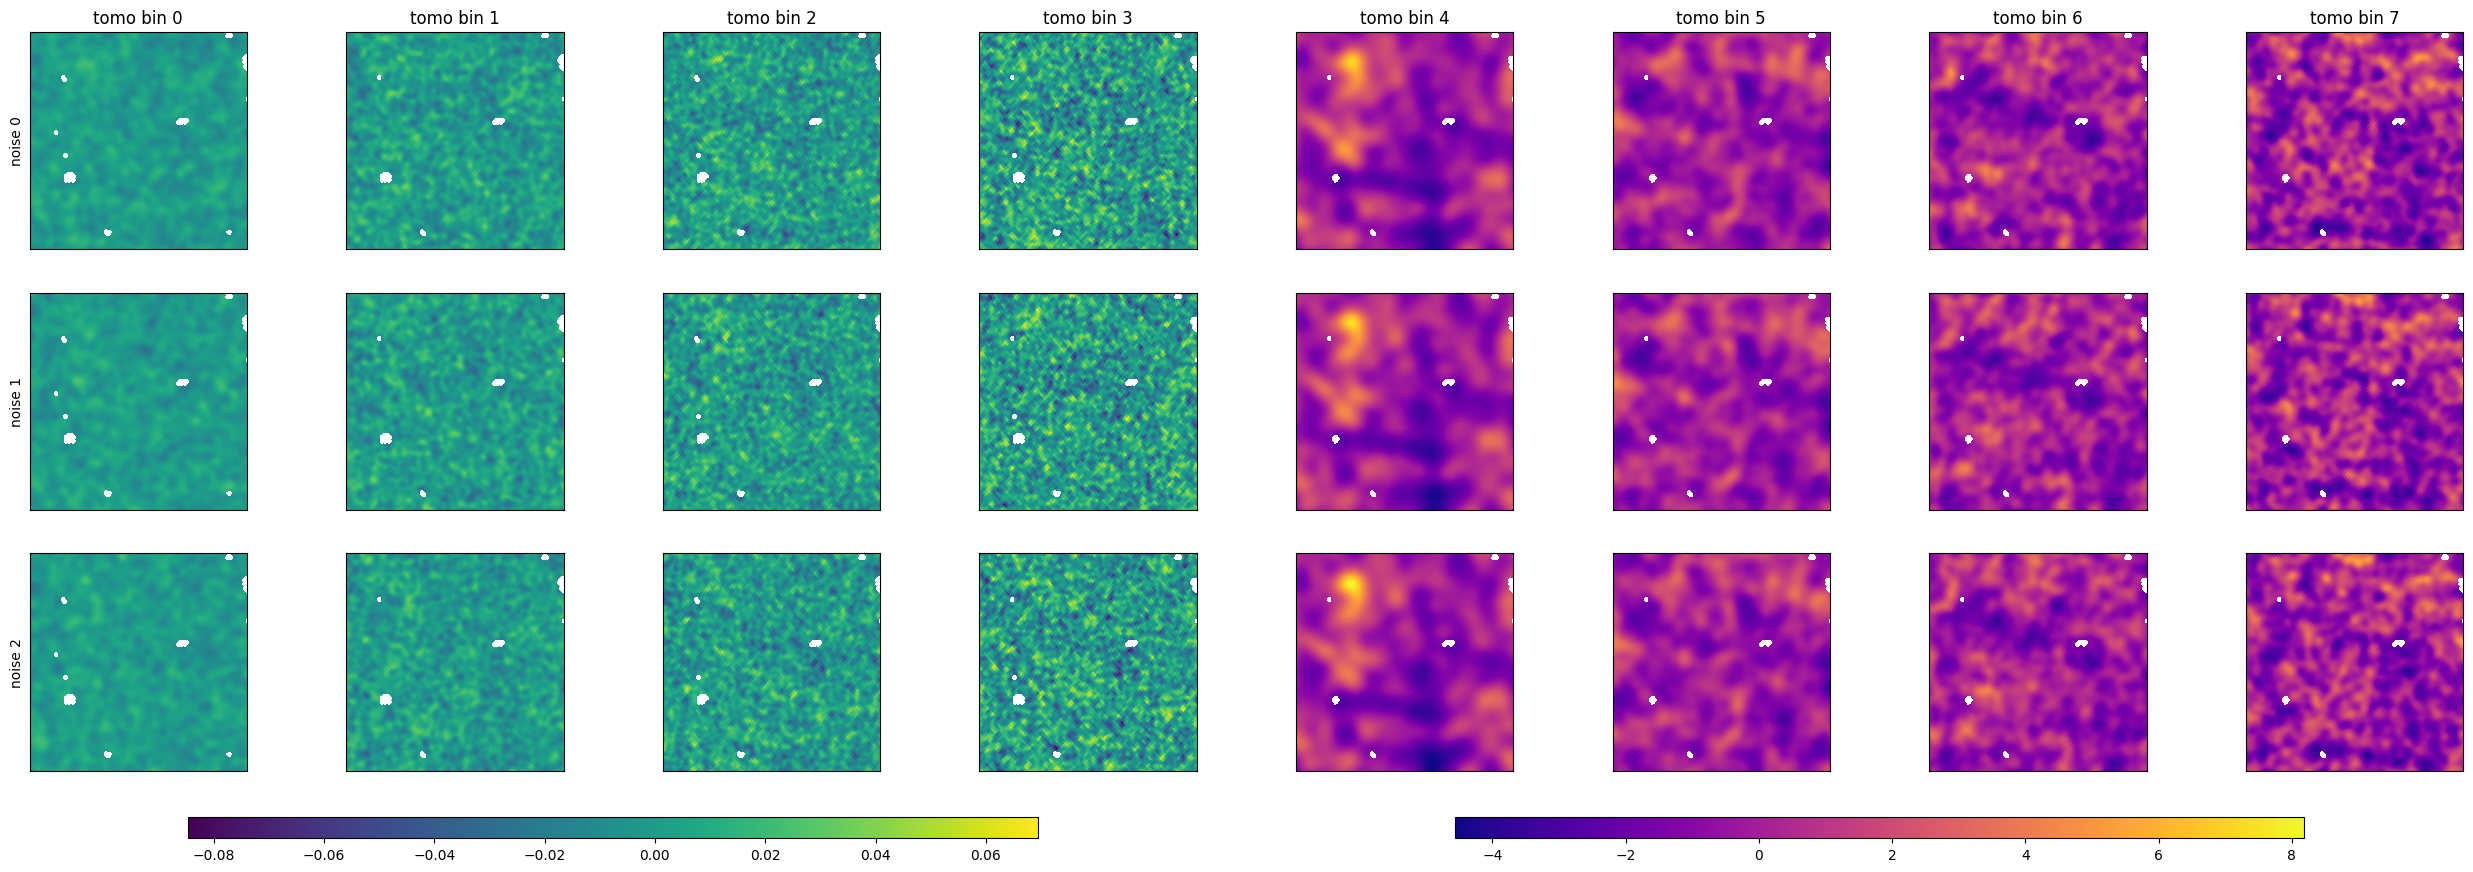

In [8]:
fig, ax = plt.subplots(figsize=(4*n_z, 4*n_noise), nrows=n_noise, ncols=n_z)

wl_min = np.array(gnoms[...,:n_z_metacal]).min()
wl_max = np.array(gnoms[...,:n_z_metacal]).max()

gc_min = np.array(gnoms[...,n_z_metacal:]).min()
gc_max = np.array(gnoms[...,n_z_metacal:]).max()

for i_n  in range(n_noise):
    for i_z in range(n_z):
        # lensing
        if i_z < n_z_metacal:
            vmin = wl_min
            vmax = wl_max
            cmap = "viridis"

        # clustering
        else:
            vmin = gc_min
            vmax = gc_max
            cmap = "plasma"

        gnom = gnoms[i_n, ..., i_z]

        im = ax[i_n, i_z].imshow(gnom, vmin=vmin, vmax=vmax, cmap=cmap)

        ax[i_n, i_z].set_xticks([])
        ax[i_n, i_z].set_yticks([])
        ax[i_n, i_z].set_aspect("equal")
        
        if i_z == 0:
            ax[i_n, i_z].set(ylabel=f"noise {i_n}")
            
        if i_n == 0:
            ax[i_n, i_z].set(title=f"tomo bin {i_z}")
            
        if i_n == n_noise - 1:
            if i_z == 0:
                fig.colorbar(im, ax=ax[:,:n_z_metacal], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
            if i_z == 4:
                fig.colorbar(im, ax=ax[:,n_z_metacal:], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
                
fig.savefig("plots/gnom_maps" + filename_suffix + ".png", bbox_inches="tight", dpi=100)

### differences to noise 0

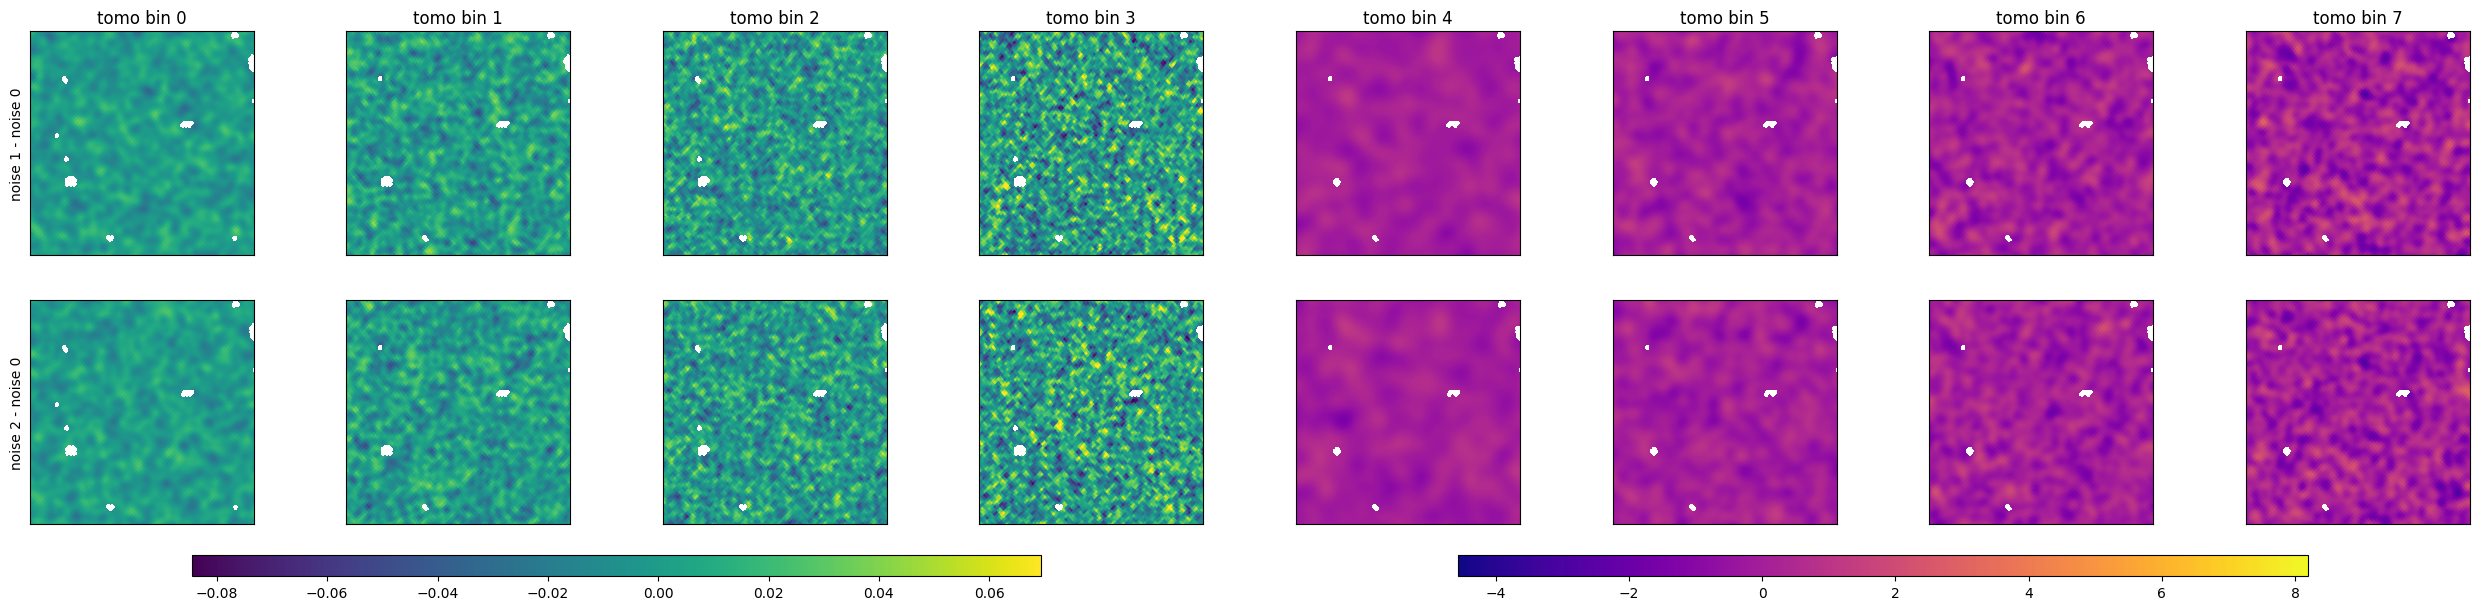

In [9]:
fig, ax = plt.subplots(figsize=(4*n_z, 4*(n_noise - 1)), nrows=n_noise - 1, ncols=n_z)

for i_n in range(n_noise - 1):
    for i_z in range(n_z):
        # lensing
        if i_z < n_z_metacal:
            vmin = wl_min
            vmax = wl_max
            cmap = "viridis"

        # clustering
        else:
            vmin = gc_min
            vmax = gc_max
            cmap = "plasma"

        gnom = gnoms[i_n+1, ..., i_z] - gnoms[0, ..., i_z]
        im = ax[i_n, i_z].imshow(gnom, vmin=vmin, vmax=vmax, cmap=cmap)

        ax[i_n, i_z].set_xticks([])
        ax[i_n, i_z].set_yticks([])
        ax[i_n, i_z].set_aspect("equal")
        
        if i_z == 0:
            ax[i_n, i_z].set(ylabel=f"noise {i_n+1} - noise 0")
            
        if i_n == 0:
            ax[i_n, i_z].set(title=f"tomo bin {i_z}")
            
        if i_n == n_noise - 2:
            if i_z == 0:
                fig.colorbar(im, ax=ax[:,:n_z_metacal], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
            if i_z == 4:
                fig.colorbar(im, ax=ax[:,n_z_metacal:], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
                
fig.savefig("plots/gnom_noise_diff" + filename_suffix + ".png", bbox_inches="tight", dpi=100)

### mollview

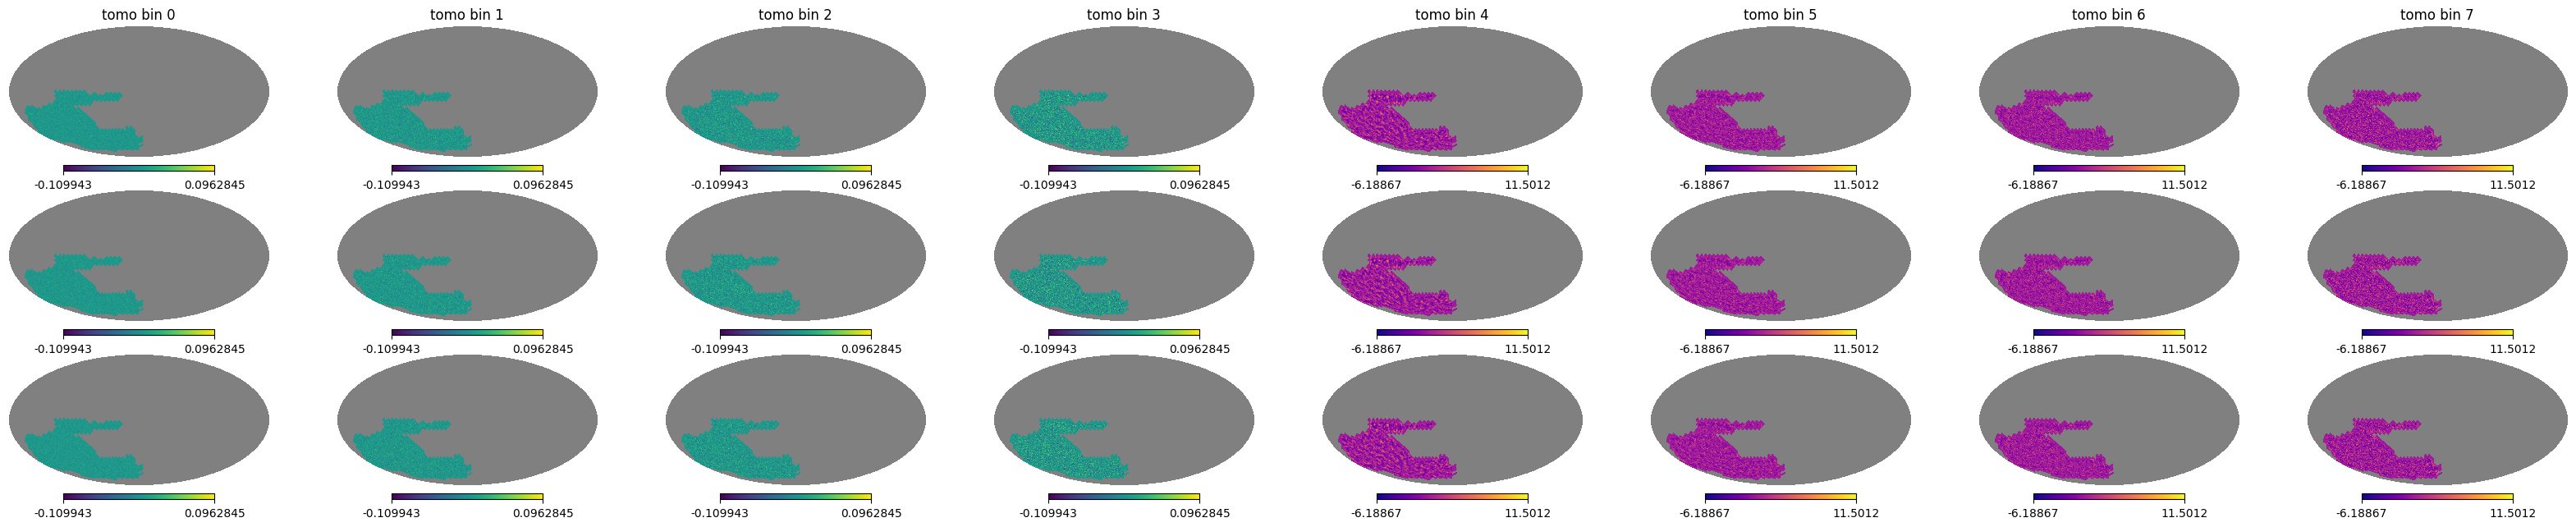

In [10]:
wl_min = np.array(dvs_noisy[...,:n_z_metacal]).min()
wl_max = np.array(dvs_noisy[...,:n_z_metacal]).max()

gc_min = np.array(dvs_noisy[...,n_z_metacal:]).min()
gc_max = np.array(dvs_noisy[...,n_z_metacal:]).max()

plt.figure(figsize=(4*n_z,2*n_noise))

i_subplot = 1
for i_n  in range(n_noise):
    for i_z in range(n_z):
        # lensing
        if i_z < n_z_metacal:
            vmin = wl_min
            vmax = wl_max
            cmap = "viridis"

        # clustering
        else:
            vmin = gc_min
            vmax = gc_max
            cmap = "plasma"
            
        if i_n == 0:
            title = f"tomo bin {i_z}"
        else:
            title = ""

        hp_map = np.full(n_pix, hp.UNSEEN)
        hp_map[data_vec_pix] = dvs_noisy[i_n,:,i_z]
        
        hp.mollview(hp_map, nest=True, cmap=cmap, sub=(n_noise,n_z,i_subplot), xsize=2000, title=title, min=vmin, max=vmax)
        i_subplot += 1

plt.savefig("plots/moll_maps" + filename_suffix + ".png", bbox_inches="tight", dpi=500)